# 투자분석 hw4

20249433 최재필


In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import yfinance as yf

## (a)

- MSFT
- GOOG
- KO

Source: Yahoo Finance

In [61]:
END = '2024-05-31'

# START = '2015-01-01'
START = pd.to_datetime(END) - pd.DateOffset(years=5)
START = START.strftime('%Y-%m-%d')


In [62]:
MSFT = yf.Ticker("MSFT") # originally MSFT
GOOG = yf.Ticker("GOOG") # originally GOOGL
KO = yf.Ticker("KO") # originally KO

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [63]:
MSFT_df = MSFT.history(start=START, end=END, interval='1mo')
MSFT_ret = MSFT_df['Close'].pct_change().dropna()
MSFT_ret = MSFT_ret.rename('MSFT')

GOOG_df = GOOG.history(start=START, end=END, interval='1mo')
GOOG_ret = GOOG_df['Close'].pct_change().dropna()
GOOG_ret = GOOG_ret.rename('GOOG')

KO_df = KO.history(start=START, end=END, interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(start=START, end=END, interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(start=START, end=END, interval='1mo')
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [64]:
MSFT_ret.index = MSFT_ret.index.to_period('M')
GOOG_ret.index = GOOG_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')
Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

Tbill3M_ret = Tbill3M_ret.reindex(MSFT_ret.index, method='ffill')

C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MSFT_ret.index = MSFT_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  GOOG_ret.index = GOOG_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index = SPY_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Tbill3M_ret.index 

In [65]:
df = pd.concat([MSFT_ret, GOOG_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
df = df.dropna()

In [66]:
# Make it excess return
excs_df = df.loc[:, ['MSFT', 'GOOG', 'KO', 'SPY']].subtract(df.loc[:, 'Tbill3M'], axis=0)
excs_df.columns = [f'{ticker}_excs' for ticker in excs_df.columns]
excs_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2024-01,0.052958,0.001850,0.005180,0.015722
2024-02,0.036042,-0.018598,0.004557,0.047834
2024-03,0.014661,0.084947,0.014991,0.025167
2024-04,-0.078981,0.076937,0.013349,-0.041709
2024-05,0.061903,0.052243,0.014414,0.046215


## (b)

In [67]:
stocks = ['MSFT', 'GOOG', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

각 종목의 초과수익률을 시장 초과수익률에 대해 regress

In [68]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(excs_df[f'{stock}_excs'], excs_df['SPY_excs'], print_summary=True)
    print('\n'*5)

SIM regression result of MSFT
                            OLS Regression Results                            
Dep. Variable:              MSFT_excs   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     65.99
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           4.29e-11
Time:                        22:40:23   Log-Likelihood:                 102.64
No. Observations:                  59   AIC:                            -201.3
Df Residuals:                      57   BIC:                            -197.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108 

In [69]:
def get_result_values(single_stock_result):
    alpha, beta = single_stock_result.params
    t_value_alpha, t_value_beta = single_stock_result.tvalues
    p_value_alpha, p_value_beta = single_stock_result.pvalues
    r_squared = single_stock_result.rsquared

    # residual std는 따로 계산해야 함
    residuals = single_stock_result.resid
    resid_df = single_stock_result.df_resid
    residual_std = np.sqrt( (residuals**2).sum() / resid_df )

    result_values = {
        'alpha': alpha,
        'beta': beta,
        't_value_alpha': t_value_alpha,
        't_value_beta': t_value_beta,
        'p_value_alpha': p_value_alpha,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'residual_std': residual_std
    }

    return result_values


In [70]:
msft_result_values = get_result_values(results['MSFT'])
goog_result_values = get_result_values(results['GOOG'])
ko_result_values = get_result_values(results['KO'])


In [71]:
msft_result_values

{'alpha': 0.010755439688503947,
 'beta': 0.8633917699337325,
 't_value_alpha': 1.8713162923554416,
 't_value_beta': 8.123469964407883,
 'p_value_alpha': 0.0664365907420225,
 'p_value_beta': 4.2875725970322834e-11,
 'r_squared': 0.5365505666890482,
 'residual_std': 0.04322248642969223}

In [72]:
goog_result_values

{'alpha': 0.009622963869259009,
 'beta': 1.0551382972710457,
 't_value_alpha': 1.3230077678017258,
 't_value_beta': 7.844722229460154,
 'p_value_alpha': 0.19111585591706287,
 'p_value_beta': 1.2450659882322096e-10,
 'r_squared': 0.5191483027485135,
 'residual_std': 0.05469847737307697}

In [73]:
ko_result_values

{'alpha': -0.0007150543531129508,
 'beta': 0.605450182580308,
 't_value_alpha': -0.12125396991232733,
 't_value_beta': 5.552006567781177,
 'p_value_alpha': 0.9039163231667333,
 'p_value_beta': 7.692959522032594e-07,
 'r_squared': 0.3509804181309264,
 'residual_std': 0.044347777959702205}

## (c)

In [74]:
mkt_excs_mean = excs_df['SPY_excs'].mean() # Market expected return
mkt_excs_std = excs_df['SPY_excs'].std() # Market expected volatility

In [75]:
ann_mkt_excs_mean = mkt_excs_mean * 12
ann_mkt_excs_std = mkt_excs_std * np.sqrt(12)

In [76]:
betas = np.array([msft_result_values['beta'], goog_result_values['beta'], ko_result_values['beta']])
betas

array([0.86339177, 1.0551383 , 0.60545018])

In [77]:
msft_excs_std = excs_df['MSFT_excs'].std()
goog_excs_std = excs_df['GOOG_excs'].std()
ko_excs_std = excs_df['KO_excs'].std()

excs_stds = np.array([msft_excs_std, goog_excs_std, ko_excs_std])
excs_stds

array([0.06294076, 0.07819754, 0.05457156])

In [78]:
ann_excs_stds = excs_stds * np.sqrt(12)

In [79]:
sys_stds = betas * ann_mkt_excs_std
sys_stds

array([0.15970847, 0.19517736, 0.11199496])

In [80]:
resid_stds = np.sqrt(ann_excs_stds**2 - sys_stds**2)
resid_stds

array([0.14843072, 0.18784052, 0.1522951 ])

In [81]:
alphas = [0.02, -0.01, 0.01] # already annualized

In [82]:
ANN_MKT_RISKPREMIUM = 0.06

riskpremiums = ANN_MKT_RISKPREMIUM * betas
riskpremiums

array([0.05180351, 0.0633083 , 0.03632701])

### 교수님 엑셀처럼 값 정리하여 optimal risky portfolio 구하기

#### $ \sigma^2(\epsilon_i) $ 

In [83]:
resid_vars = resid_stds**2
resid_vars

array([0.02203168, 0.03528406, 0.0231938 ])

#### $ \alpha_i / \sigma^2(\epsilon_i) $

In [84]:
alpha_div_resid_vars = alphas / resid_vars
alpha_div_resid_vars

array([ 0.90778373, -0.28341408,  0.43114977])

#### $ w_i $

In [85]:
weights = alpha_div_resid_vars / alpha_div_resid_vars.sum()
weights

array([ 0.86003508, -0.26850674,  0.40847166])

In [86]:
np.round(weights.sum(), 10)

1.0

#### $ \alpha_A $

In [87]:
weighted_alpha = weights @ alphas
weighted_alpha

0.023970485490495796

#### $ \beta_A $

In [88]:
weighted_beta = weights @ betas
weighted_beta

0.706544706704172

#### $ \sigma^2(\epsilon_A) $ - residual variance

In [89]:
active_residual_var = weights**2 @ resid_vars
active_residual_var

0.022709658291175196

#### $ \sigma_A^2 $ - active portfolio variance


In [90]:
active_port_var = weighted_beta**2 * ann_mkt_excs_std**2 + active_residual_var
active_port_var

0.03979089806154244

#### $ w_A^0 $

In [91]:
w_A_0 = (weighted_alpha / active_residual_var) / (mkt_excs_mean / mkt_excs_std**2) # 여기서 lookahead std로 넣었다. 원래는 historical 쓰던데.
w_A_0

0.273301149385793

#### $ w_A^* $

In [92]:
w_A_star = w_A_0 / (1 + w_A_0 * (1 - weighted_beta))
w_A_star

0.2530093752319193

개별 주식 weight

In [93]:
final_weights = w_A_star * weights
final_weights

array([ 0.21759694, -0.06793472,  0.10334716])

#### $ w_M^* $

In [94]:
w_M_star = 1 - w_A_star
w_M_star

0.7469906247680806

### 그래프 확인

In [95]:
final_weights

array([ 0.21759694, -0.06793472,  0.10334716])

<Axes: xlabel='Date'>

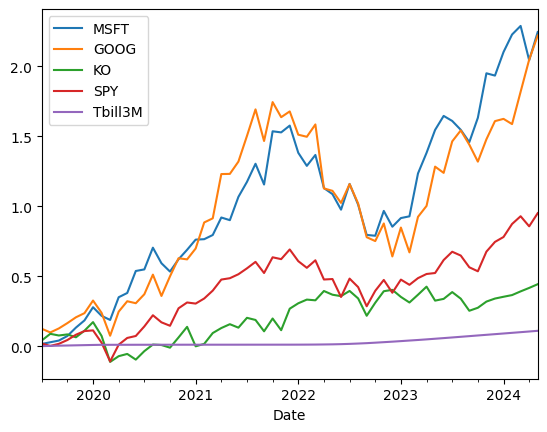

In [96]:
((1 + df).cumprod() - 1).plot()

In [97]:
final_alpha = final_weights @ alphas
final_alpha

0.006064757557956127

In [98]:
final_std = np.sqrt(final_weights @ resid_vars)
final_std

0.06923890478012786

## (d)

Information ratio

In [99]:
information_ratio = final_alpha / final_std
information_ratio

0.08759176040139738

## (e)

In [100]:
active_riskpremium = final_weights @ riskpremiums
active_riskpremium

0.010725746088998532

In [101]:
optimal_riskpremium = ANN_MKT_RISKPREMIUM * w_M_star + active_riskpremium * w_A_star
optimal_riskpremium

0.047533151802958556

In [102]:
market_sharpe = ANN_MKT_RISKPREMIUM / ann_mkt_excs_std
market_sharpe

0.3243629211989669

In [103]:
optimal_sharpe = np.sqrt(market_sharpe ** 2 + information_ratio ** 2)
optimal_sharpe

0.3359815785708244